In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (ScalarFormatter, MultipleLocator, AutoMinorLocator)
import numpy as np
from scipy import fft, signal
%matplotlib inline

x = np.arange(-10, 10, 0.1)

## Distortion
### nonlinear transfer functions
Let's look at some nonlinear transfer function to achieve saturation/distortion. These take an arbitrary input signal and compress it into a range from -1/1, in a nonlinear fashion.

#### from DAFX book
See https://dsp.stackexchange.com/questions/13142/digital-distortion-effect-algorithm

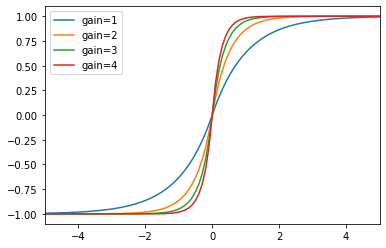

In [6]:
def distortion_dafx(x, gain=1, makeup=False):
    y = x * gain
    out = (y / np.absolute(y)) * (1-np.exp(-1*np.absolute(y)))
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = (gain / np.absolute(gain)) * (1-np.exp(-1*np.absolute(gain)))
        return out / out_m
    else:
        return out

for i in [1, 2, 3, 4]:
    plt.plot(x, distortion_dafx(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### tanh

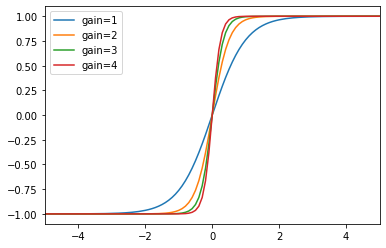

In [7]:
def tanh_alt(x, gain=1, makeup=False):
    y = x * gain
    out = 2 / (1 + np.exp(-2*y)) - 1
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = 2 / (1 + np.exp(-2*gain)) - 1
        return out / out_m
    else:
        return out

#plt.plot(x, np.tanh(x), x, tanh_alt(x))
for i in [1, 2, 3, 4]:
    plt.plot(x, tanh_alt(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### sigmoid

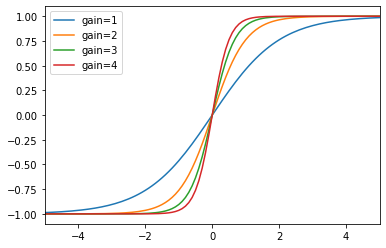

In [8]:
def sigmoid_bipolar(x, gain=1, makeup=False):
    y = x * gain
    out = (1 - np.exp(-y)) / (1 + np.exp(-y))
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = (1 - np.exp(-gain)) / (1 + np.exp(-gain))
        return out / out_m
    else:
        return out

for i in [1, 2, 3, 4]:
    plt.plot(x, sigmoid_bipolar(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### hard clipping

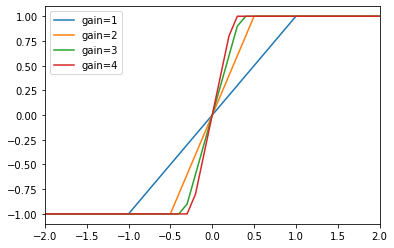

In [9]:
def hard_clipping(x, gain=1):
    y = x * gain
    return np.where(y > 1, 1, np.where(y < -1, -1, y))

for i in [1, 2, 3, 4]:
    plt.plot(x, hard_clipping(x, gain=i), label='gain={}'.format(i))
plt.xlim(-2, 2)
plt.legend()

#### polymonial

In [10]:
def distortion_poly(x, deg=3, gain=1, makeup=False):
    if deg % 2 != 1:
        raise ValueError('polynomial degree {} must be odd integer'.format(deg))
    y = x * gain
    out = np.where(
        y > 1, (deg - 1) / deg,
        np.where(
            y < -1, -(deg-1)/deg,
            y - y ** deg / deg
        )
    )
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = np.where(
            gain > 1, (deg - 1) / deg,
            np.where(
                gain < -1, -(deg-1)/deg,
                gain - gain ** deg / deg
            )
        )
        return out / out_m
    else:
        return out
    

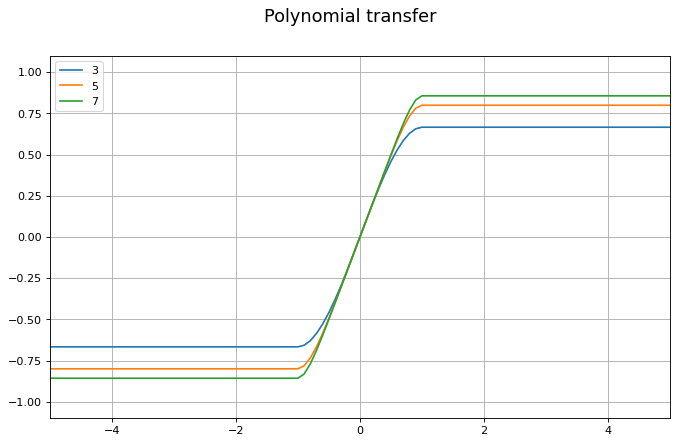

In [11]:
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Polynomial transfer', fontsize=16)
ax = fig.add_subplot(111)
for i in [3, 5, 7]:
    ax.plot(x, distortion_poly(x, deg=i, makeup=False), label=i)
ax.set_xlim(-5, 5)
ax.set_ylim(-1.1, 1.1)
ax.grid(True)
ax.legend()

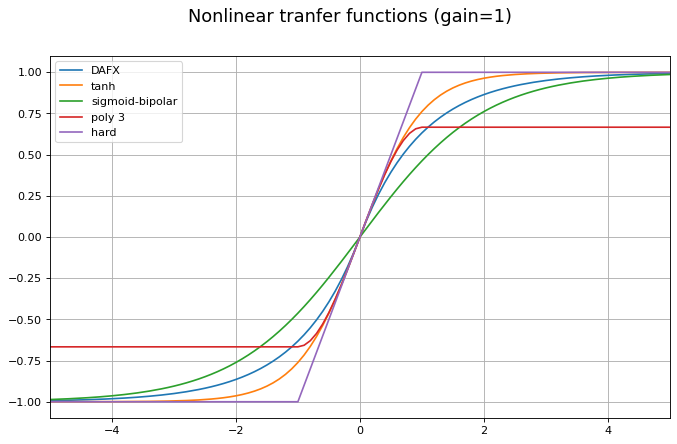

In [12]:
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Nonlinear tranfer functions (gain=1)', fontsize=16)
ax = fig.add_subplot(111)
ax.plot(x, distortion_dafx(x), label='DAFX')
ax.plot(x, np.tanh(x), label='tanh')
ax.plot(x, sigmoid_bipolar(x), label='sigmoid-bipolar')
ax.plot(x, distortion_poly(x, 3), label='poly 3')
ax.plot(x, hard_clipping(x), label='hard')
ax.set_xlim(-5, 5)
ax.grid(True)
ax.legend()

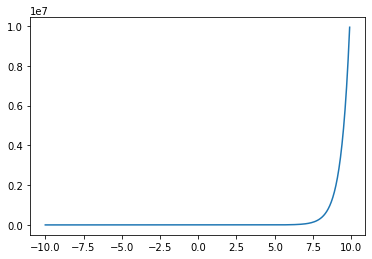

In [13]:
def shockley_diode(x, alpha=1.79, beta=0.2):
    return beta * (np.exp(alpha*x) - 1.0)

plt.plot(x, shockley_diode(x))

### Makeup gain
Investigate how much makeup gain is required for input=1 to give output=1

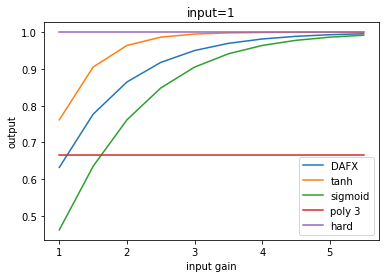

In [14]:
g = np.arange(1, 6, 0.5)
plt.plot(g, distortion_dafx(1, gain=g), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g), label='sigmoid')
plt.plot(g, distortion_poly(1, deg=3, gain=g), label='poly 3')
plt.plot(g, hard_clipping(1, gain=g), label='hard')
plt.xlabel('input gain')
plt.ylabel('output')
plt.title('input=1')
plt.legend()

There is some signal loss with all transfer functions, except the hard clipping, and it varies with the input gain applied. We should be able to normalize the output by calculating the the max output (from input signal=1) and then divide the distorted output by this factor.

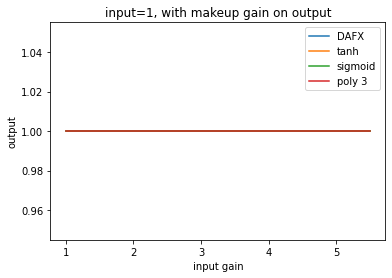

In [15]:
plt.plot(g, distortion_dafx(1, gain=g, makeup=True), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g, makeup=True), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g, makeup=True), label='sigmoid')
plt.plot(g, distortion_poly(1, deg=3, gain=g, makeup=True), label='poly 3')
plt.xlabel('input gain')
plt.ylabel('output')
plt.title('input=1, with makeup gain on output')
plt.legend()

## Applied distortion
Examine distortion effects by looking at their affect on a sine wave input

In [16]:
def sine_wave(x, freq, fs):
    return np.sin(2 * np.pi * x * freq / fs)

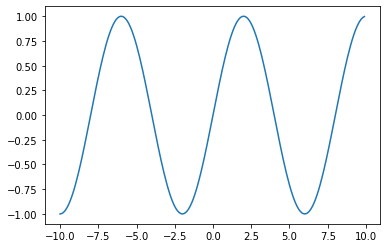

In [17]:
fs = 48000
freq = fs / 8
plt.plot(x, sine_wave(x, freq, fs))

### Distortion effect on waveform
Look at the waveform of a distortion effect on a sine wave input

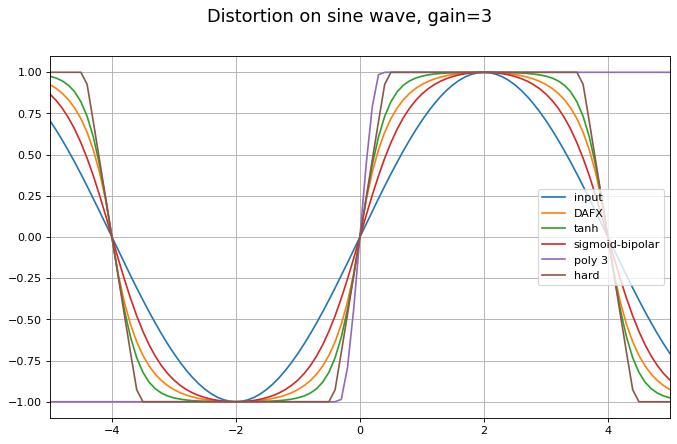

In [18]:
gain = 3
makeup = True
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Distortion on sine wave, gain={}'.format(gain), fontsize=16)
ax = fig.add_subplot(111)
ax.plot(x, sine_wave(x, freq, fs), label='input')
ax.plot(x, distortion_dafx(sine_wave(x, freq, fs), gain=gain, makeup=makeup), label='DAFX')
ax.plot(x, tanh_alt(sine_wave(x, freq, fs), gain=gain, makeup=makeup), label='tanh')
ax.plot(x, sigmoid_bipolar(sine_wave(x, freq, fs), gain=gain, makeup=makeup), label='sigmoid-bipolar')
ax.plot(x, distortion_poly(x, deg=3, gain=gain, makeup=makeup), label='poly 3')
ax.plot(x, hard_clipping(sine_wave(x, freq, fs), gain=gain), label='hard')
ax.set_xlim(-5, 5)
ax.grid(True)
ax.legend()

### Distortion frequency analysis
Look at the spectral response of a distortion effect on a sine wave input to see the added harmonic content

In [19]:
def plot_spectrum(data, fs, ax, label='', power=True, log=False):
    n = len(data) 
    freq = fft.fft(data)
    freq = freq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
    mag = np.abs(freq) # Magnitude
    mag = mag / float(n)
    # power spectrum
    if power:
        mag = mag ** 2
        ax.set_ylabel('Power spectrum (dB)')
    else:
        ax.set_ylabel('Spectrum (dB)')
    if n % 2 > 0: # ffte odd 
        mag[1:len(mag)] = mag[1:len(mag)] * 2
    else:# fft even
        mag[1:len(mag) -1] = mag[1:len(mag) - 1] * 2

    freq_axis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
    ax.plot(freq_axis/1000.0, 10*np.log10(mag), label=label) #Power spectrum
    if log:
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel('Frequency (kHz)')
    ax.set_title('Spectrum')

def plot_spectrogram(data, fs, ax, db=True, log=False):
    frame = 512 #Number of point in the fft
    f, t, Sxx = signal.spectrogram(data, fs,window = signal.blackman(frame),nfft=frame)
    if db:
        ax.pcolormesh(t, f, 10*np.log10(Sxx), shading='auto') # dB spectrogram
        ax.set_title('Spectrogram dB')
    else:
        ax.pcolormesh(t, f, Sxx, shading='auto') # Linear spectrogram
        ax.set_title('Spectrogram linear')
    if log:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (sec)')

In [20]:
sine_hz = 440
sec = 1
t = np.linspace(0, sec, fs * sec)
y = np.sin(sine_hz * 2 * np.pi * t)

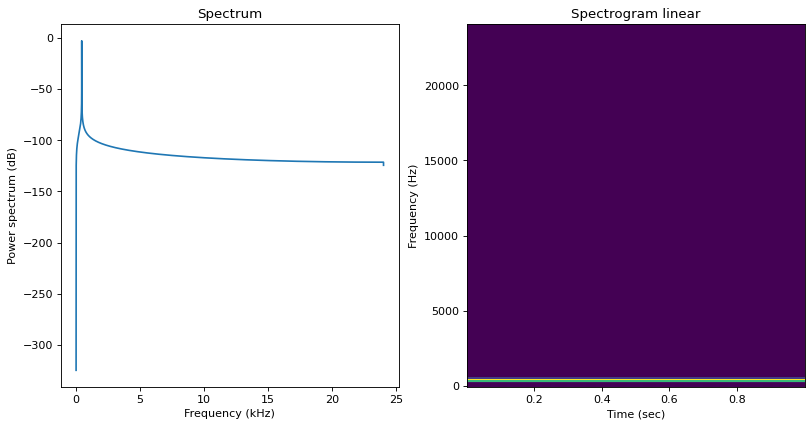

In [21]:
fig = plt.figure(figsize=(12, 6), dpi=80)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_spectrum(y, fs, ax1, power=True, log=False)
plot_spectrogram(y, fs, ax2, db=False, log=False)

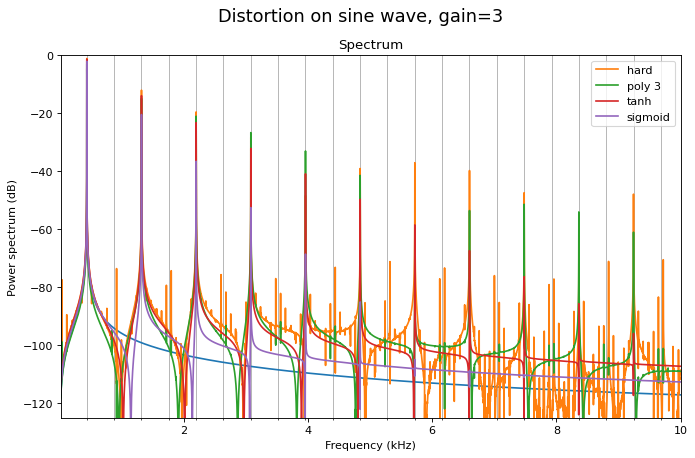

In [22]:
gain = 3
makeup = True
power = True
log = False
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Distortion on sine wave, gain={}'.format(gain), fontsize=16)
ax = fig.add_subplot(111)
plot_spectrum(y, fs, ax, power=power, log=log)
plot_spectrum(list(map(
    lambda x: hard_clipping(x, gain=gain), y)
                  ), fs, ax, label='hard', power=power, log=log)
plot_spectrum(list(map(
    lambda x: distortion_poly(x, deg=3, gain=gain), y)
                  ), fs, ax, label='poly 3', power=power, log=log)
plot_spectrum(list(map(
    lambda x: tanh_alt(x, gain=gain, makeup=makeup), y)
                  ), fs, ax, label='tanh', power=power, log=log)
plot_spectrum(list(map(
    lambda x: sigmoid_bipolar(x, gain=gain, makeup=makeup), y)
                  ), fs, ax, label='sigmoid', power=power, log=log)
ax.set_xlim(.02, 10)
ax.xaxis.set_minor_locator(MultipleLocator(sine_hz/1000.0))
ax.xaxis.grid(True, which='minor')
ax.set_ylim(-125, 0)
ax.legend()

## Profiling
Measure the relative performance of the nonlinear transfer functions. This may be of interest in realtime applications, especially on embedded devices with limited CPU (eg NTS-1).

In [23]:
import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class SatTimer():
    FS = 48000
    SINE_HZ = 440
    SEC = 10
    def __init__(self, sec=SEC):
        t = np.linspace(0, sec, self.FS * sec)
        self.y = np.sin(self.SINE_HZ * 2 * np.pi * t)
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and return the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time

tanh:		0.28106270 seconds
sigmoid:	0.35724920 seconds
poly 3:		0.59416270 seconds
hard:		0.33549350 seconds


Text(0.5, 1.0, 'distortion times (1 sec sample)')

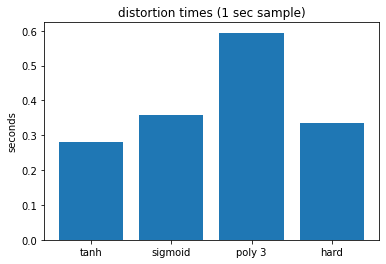

In [35]:
gain = 3
makeup = True
sec = 1
funcs = []
times = []
t = SatTimer(sec=sec)

t.start()
list(map(lambda x: tanh_alt(x, gain=gain, makeup=makeup), t.y))
elapsed = t.stop()
funcs.append('tanh')
times.append(elapsed)
print(f"tanh:\t\t{elapsed:0.8f} seconds")

t.start()
list(map(lambda x: sigmoid_bipolar(x, gain=gain, makeup=makeup), t.y))
elapsed = t.stop()
funcs.append('sigmoid')
times.append(elapsed)
print(f"sigmoid:\t{elapsed:0.8f} seconds")

t.start()
list(map(lambda x: distortion_poly(x, deg=3, gain=gain, makeup=makeup), t.y))
elapsed = t.stop()
funcs.append('poly 3')
times.append(elapsed)
print(f"poly 3:\t\t{elapsed:0.8f} seconds")

t.start()
list(map(lambda x: hard_clipping(x, gain=gain), t.y))
elapsed = t.stop()
funcs.append('hard')
times.append(elapsed)
print(f"hard:\t\t{elapsed:0.8f} seconds")

x_pos = [i for i, _ in enumerate(funcs)]
plt.bar(x_pos, times)
plt.xticks(x_pos, funcs)
plt.ylabel('seconds')
plt.title('distortion times ({} sec sample)'.format(sec))

## Play sound
### Play sine wave with saturation

In [25]:
import pyaudio

def open_pyaudio(index=2, fs=48000, channels=1):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32,
                channels=channels,
                rate=fs,
                frames_per_buffer=1024,
                output=True,
                output_device_index=index
                )
    return stream

In [26]:
sec = 2
sine_hz = 440
fs = 48000

stream = open_pyaudio()
sine_array = np.sin(sine_hz * 2 * np.pi * np.linspace(0, sec, fs * sec))
#sine_array = np.sin(np.arange(48000)/20)
#stream.write(sine_array.astype(np.float32).tobytes())
stream.close()

In [27]:
gain = 3
makeup = False

sine_sat = np.fromiter(map(lambda x: tanh_alt(x, gain=gain, makeup=makeup), sine_array), dtype=np.float32)
#sine_sat = np.fromiter(map(lambda x: sigmoid_bipolar(x, gain=gain, makeup=makeup), sine_array), dtype=np.float32)
#sine_sat = np.fromiter(map(lambda x: distortion_poly(x, deg=3, gain=gain, makeup=makeup), sine_array), dtype=np.float32)
#sine_sat = np.fromiter(map(lambda x: hard_clipping(x, gain=gain), sine_array), dtype=np.float32)
stream = open_pyaudio()
#stream.write(sine_sat.astype(np.float32).tobytes())
stream.close()

### Play wav file, then with saturation
Look at a more complex sound than a simple sine wave to get a better feel of the saturation musical effect.

Change the name of the wav file to something you have in your environment (I may not put my sample wav in the git repo).
Uncomment the `stream-write(...` lines to play audio. Note the the saturated version is likely to be much louder than the original in this section, we will try to remedy that in the next section.

In [28]:
import soundfile as sf

wf = sf.SoundFile('geetar.wav')
orig = wf.read(-1)
if wf.channels == 2:
    # convert stereo to mono
    orig = np.sum(orig.astype(float), axis=1) / 2
fs = wf.samplerate
wf.close()
#orig, fs = sf.read('geetar.wav')

In [29]:
print(orig.max(), orig.min())

0.5088261365890503 -0.5689718127250671


The saturation functions, if gain is applied, will increase the volume so let's normalize the input wav to -1/1

In [30]:
orig /= np.max(np.abs(orig),axis=0)
print(orig.max(), orig.min())

0.8942905873527344 -1.0


In [91]:
gain = 5
makeup = False

stream = open_pyaudio(index=2, fs=fs, channels=1)
#stream.write(orig.astype(np.float32).tobytes())
wf_tanh = np.fromiter(map(lambda x: tanh_alt(x, gain=gain, makeup=makeup), orig), dtype=np.float32)
wf_sigmoid = np.fromiter(map(lambda x: sigmoid_bipolar(x, gain=gain, makeup=makeup), orig), dtype=np.float32)
wf_hard = np.fromiter(map(lambda x: hard_clipping(x, gain=gain), orig), dtype=np.float32)
#stream.write(wf_tanh.astype(np.float32).tobytes())
stream.close()
print(wf_tanh.max(), wf_tanh.min())
print(wf_sigmoid.max(), wf_hard.min())
print(wf_hard.max(), wf_hard.min())

0.9997387 -0.9999092
0.97739697 -1.0
1.0 -1.0


### Numerical analysis
#### Normalize saturated and original volumes

In [32]:
def audio_power(data, fs):
    return 1.0 / (2 * (data.size) + 1) * np.sum(data.astype(float) ** 2) / fs

In [92]:
print(audio_power(wf_tanh, fs=fs) / audio_power(orig, fs=fs))
print(audio_power(wf_sigmoid, fs=fs) / audio_power(orig, fs=fs))
print(audio_power(wf_hard, fs=fs) / audio_power(orig, fs=fs))

10.654917587688326
4.39007733408302
13.862613423195564


Even with the peaks normalized to 1 on the original, the saturated version is (unsurprisingly) louder. Let's try to get them closer before we do more comparisons.

In [94]:
from pydub import AudioSegment
from pydub.playback import play

def seg_from_ndarray(data, fs, ch=1):
    return pydub.AudioSegment(
        data.astype(np.float32).tobytes(),
        frame_rate=fs,
        sample_width=data.astype(np.float32).dtype.itemsize,
        channels=ch
)
orig_seg = seg_from_ndarray(orig, 48000, 1)
tanh_seg = seg_from_ndarray(wf_tanh, 48000, 1)
sigmoid_seg = seg_from_ndarray(wf_sigmoid, 48000, 1)
hard_seg = seg_from_ndarray(wf_hard, 48000, 1)
print(orig_seg.dBFS, tanh_seg.dBFS, sigmoid_seg.dBFS, hard_seg.dBFS)
print(orig_seg.max_dBFS, tanh_seg.max_dBFS, sigmoid_seg.max_dBFS, hard_seg.max_dBFS)

-6.009927313670548 -6.0143535459300415 -6.012805813381314 -6.014215310244774
-2.3717281016399774 -4.650627337856614 -4.5928628673914105 -2.4745501723172687


Well, that looks pretty close even though saturated "sounds" louder to my ear. Could be the compression, though I would expect that to show in the dBFS. Let's try some analysis as-is, revisit loudness as needed.

#### Plot spectrograms

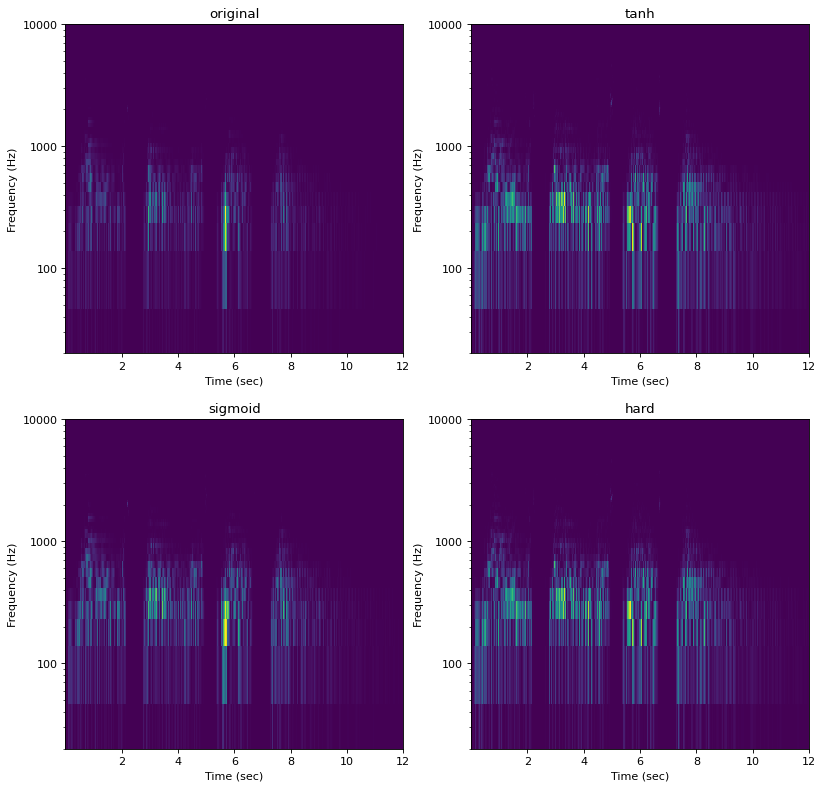

In [97]:
db = False
log = False

fig = plt.figure(figsize=(12, 12), dpi=80)
ax_o = fig.add_subplot(221)
ax_t = fig.add_subplot(222)
ax_s = fig.add_subplot(223)
ax_h = fig.add_subplot(224)
plot_spectrogram(orig, fs, ax_o, db=db, log=log)
plot_spectrogram(wf_tanh, fs, ax_t, db=db, log=log)
plot_spectrogram(wf_sigmoid, fs, ax_s, db=db, log=log)
plot_spectrogram(wf_hard, fs, ax_h, db=db, log=log)
ax_o.set_title('original')
ax_t.set_title('tanh')
ax_s.set_title('sigmoid')
ax_h.set_title('hard')
for ax in [ax_o, ax_t, ax_s, ax_h]:
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylim(20,10000)

[Text(0.5, 1.0, 'hard')]

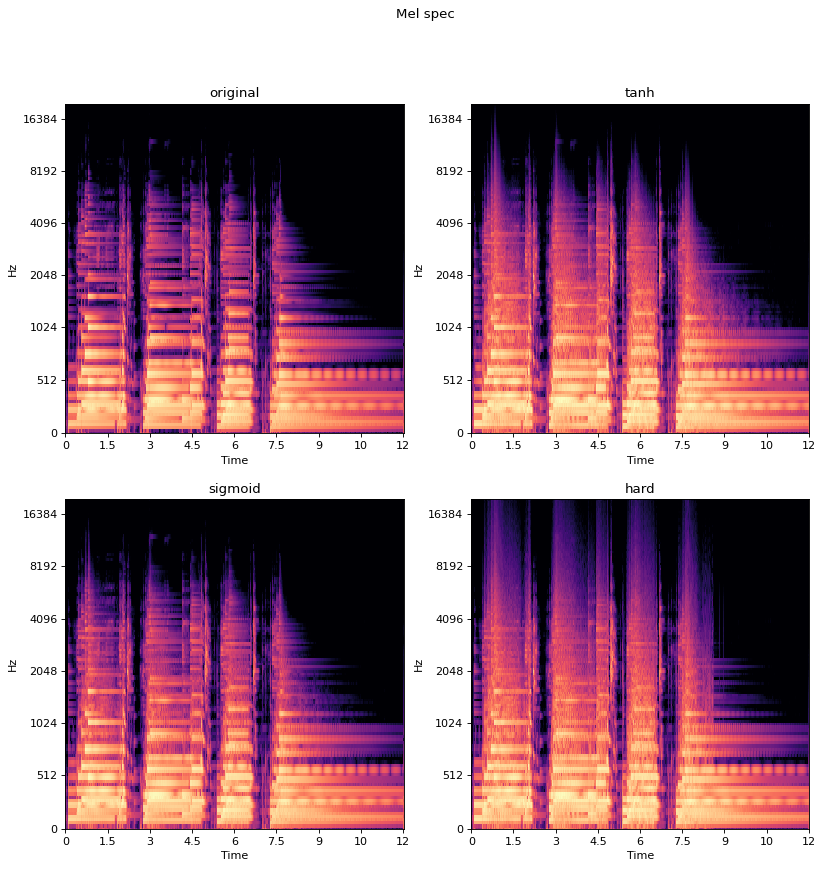

In [105]:
import librosa, librosa.display

n_mels = 128
fmax = 20000

fig = plt.figure(figsize=(12, 12), dpi=80)
fig.suptitle('Mel spec')
ax_o = fig.add_subplot(221)
ax_t = fig.add_subplot(222)
ax_s = fig.add_subplot(223)
ax_h = fig.add_subplot(224)

S = librosa.feature.melspectrogram(y=orig, sr=fs, n_mels=n_mels, fmax=fmax)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=fmax, ax=ax_o)
ax_o.set(title='original')
S = librosa.feature.melspectrogram(y=wf_tanh, sr=fs, n_mels=n_mels, fmax=fmax)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=fmax, ax=ax_t)
ax_t.set(title='tanh')
S = librosa.feature.melspectrogram(y=wf_sigmoid, sr=fs, n_mels=n_mels, fmax=fmax)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=fmax, ax=ax_s)
ax_s.set(title='sigmoid')
S = librosa.feature.melspectrogram(y=wf_hard, sr=fs, n_mels=n_mels, fmax=fmax)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=fmax, ax=ax_h)
ax_h.set(title='hard')
#for ax in [ax_o, ax_t, ax_s, ax_h]:
#    fig.colorbar(img, ax=ax, format='%+2.0f dB')